# Principle Component Analysis

This document is based on: [Principal Component Analysis from Scratch](https://bagheri365.github.io/blog/Principal-Component-Analysis-from-Scratch/)

There are some differences: 
- svd decomposition of the covariance matrix is used instead of the Eigen decomposition. Thus, the Eigen value and vector pairs are always in non-ascending order.
- Additional Eigen value correction is an optional step which is needed to obtain identical results with scikit-learn.

## What is PCA?

Greenacre, M., Groenen, P.J.F., Hastie, T. et al. Principal component analysis. Nat Rev Methods Primers 2, 100 (2022):
* PCA reduces a cases-by-variables data table to its essential features, called principal components. 
* Principal components are a few linear combinations of the original variables that maximally explain the variance of all the variables. 
* The method provides an approximation of the original data table using only these few major components.
    

## Preparations

In [129]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size": 8,
})

np.set_printoptions(precision=3, suppress=True)


## Iris Dataset

The iris data is ideal for our learning purpose since the data has only 4 features: `sepal-length`, `sepal-width`, `petal-length`, and `petal-width`.

More information about iris plan can be found here this [Wikipedia link](https://en.wikipedia.org/wiki/Iris_(plant)).

### Load the Dataset

In [130]:
data = np.loadtxt("./datasets/iris/iris.data", delimiter=",", dtype=str)
X = np.float32(data[:, 0:4])  # 4 features

# Change the labels: string labels to numerical labels:
# Iris-setosa     = 0
# Iris-versicolor = 1
# Iris-virginica  = 2
y = np.zeros(X.shape[0], dtype=np.int32) 
y[np.where(data[:,-1]=='Iris-setosa')]     = 0
y[np.where(data[:,-1]=='Iris-versicolor')] = 1
y[np.where(data[:,-1]=='Iris-virginica')]  = 2

feature_names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width']
n_features = X.shape[1]

print("Feature numbers :", X.shape[1])
print("Number of data  :", X.shape[0])
print("Labels          :", np.unique(y))

Feature numbers : 4
Number of data  : 150
Labels          : [0 1 2]


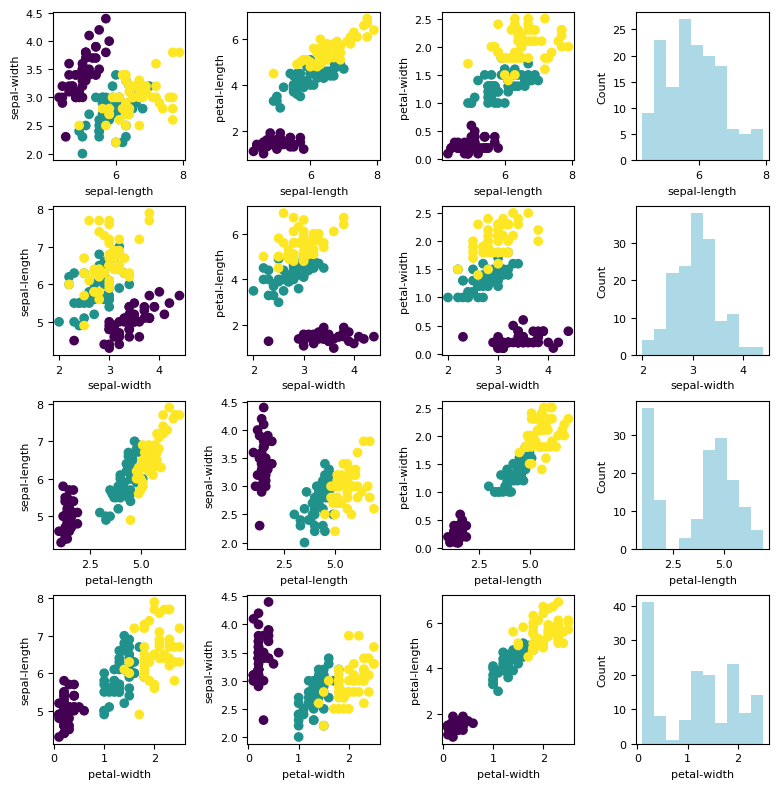

In [131]:
%matplotlib inline

fig, ax = plt.subplots(nrows=n_features, ncols=n_features, figsize= (n_features*2, n_features*2))
fig.tight_layout(pad=2.0)

names = feature_names

for i in range(n_features):
    J = np.arange(n_features)
    J = np.delete(J, i)
    for k, j in enumerate(J):
        ax[i, k].scatter(X[:, i], X[:, j], c = y)
        ax[i, k].set_xlabel(names[i])
        ax[i, k].set_ylabel(names[j])
        
for i in range(n_features):
    ax[i, -1].hist(X[:, i], color = 'lightblue')
    ax[i, -1].set_ylabel('Count')
    ax[i, -1].set_xlabel(names[i])

### Standardization

Definition:

$$ \mathrm{X_{\text{std}}}=\frac{\mathrm{X}-\text { Mean }}{\text { Standard deviation }} $$

In [132]:
means  = np.mean(X, axis=0)
stdevs = np.std(X, axis=0)

X_std = (X - means) / stdevs

Let us plot the standardized dataset.

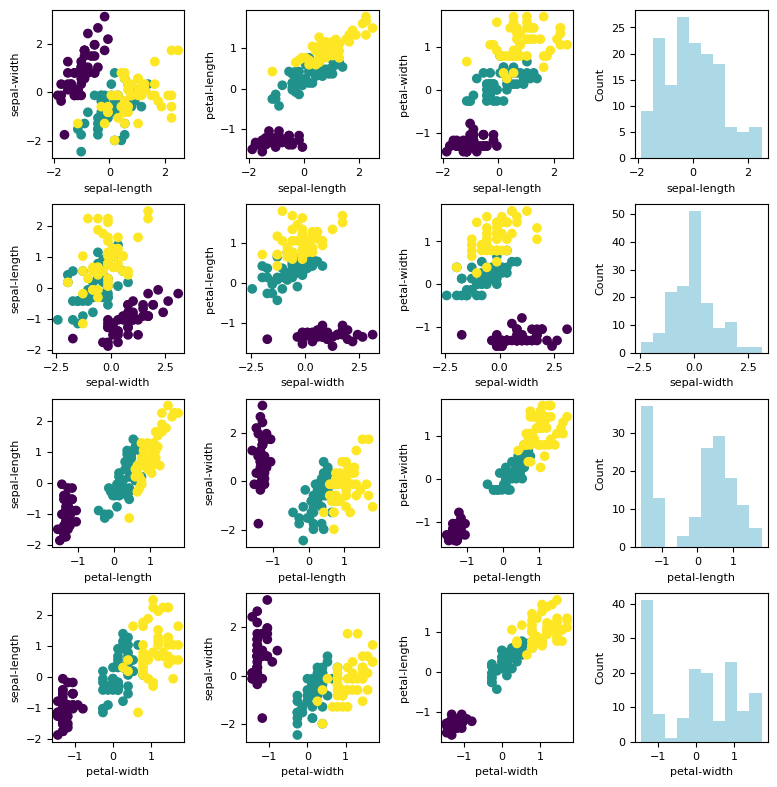

In [133]:
%matplotlib inline

fig, ax = plt.subplots(nrows=n_features, ncols=n_features, figsize= (n_features*2, n_features*2))
fig.tight_layout(pad=2.0)

names = feature_names

for i in range(n_features):
    J = np.arange(n_features)
    J = np.delete(J, i)
    for k, j in enumerate(J):
        ax[i, k].scatter(X_std[:, i], X_std[:, j], c = y)
        ax[i, k].set_xlabel(names[i])
        ax[i, k].set_ylabel(names[j])
        
for i in range(n_features):
    ax[i, -1].hist(X_std[:, i], color = 'lightblue')
    ax[i, -1].set_ylabel('Count')
    ax[i, -1].set_xlabel(names[i])

### Covariance Matrix

Defintion:

$$\left[\begin{array}{cccc}\operatorname{Var}\left(x_1\right) & \cdots & \operatorname{Cov}\left(x_{n}, x_1\right) \\ \vdots & \ddots & & \vdots \\ \vdots & \ddots & \vdots \\ \operatorname{Cov}\left(x_{n,}, x_1\right) & \cdots & \operatorname{Var}^2\left(x_{n}\right)\end{array}\right]$$

where:

$$\operatorname{Cov}(x, y)=\frac{\sum(x-\bar{x})(y-y)}{N-1}$$

and

$$\operatorname{Var}(x)=\frac{\sum(x-\bar{x})^2}{N-1}$$

In [134]:
cov_mat = np.cov(X_std.T) # square symmetric, positive semi-definite
cov_mat

array([[ 1.007, -0.11 ,  0.878,  0.823],
       [-0.11 ,  1.007, -0.423, -0.359],
       [ 0.878, -0.423,  1.007,  0.969],
       [ 0.823, -0.359,  0.969,  1.007]])

### Singular Value Decompostion

Defintion:

$$ A=U \Sigma V^T$$

For square symmetric positive semi-definite matrix (such as covariance matrix), the eigenvalues and $\operatorname{diag}(\Sigma)$ are exactly the same and $U$ is the Eigen-vector matrix.

In [135]:
U, S, V = np.linalg.svd(cov_mat)
eig_vals = S
eig_vecs = U

print ("Eigen values (lambda):")
print(S)
print()
print("Corresponding Eigen-vector matrix (U):")
print(U)

Eigen values (lambda):
[2.93  0.927 0.148 0.021]

Corresponding Eigen-vector matrix (U):
[[-0.522 -0.372  0.721  0.262]
 [ 0.263 -0.926 -0.242 -0.124]
 [-0.581 -0.021 -0.141 -0.801]
 [-0.566 -0.065 -0.634  0.524]]


### Correct the Eigen-vector Matrix

__This section is actually optional. This step is necessary if we want to keep our results identical to PCA from scikit-learn.__

Correct the Eigen matrix such that:
* for each column, find the __largest absolute__ value
* if the __largest absolute__ value comes from a negative value, make it positive by multiplying the entire column with -1

In [136]:
# Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
eig_vecs_ = eig_vecs*signs[np.newaxis,:]

print(eig_vals)
print()
print(eig_vecs_)

[2.93  0.927 0.148 0.021]

[[ 0.522  0.372  0.721 -0.262]
 [-0.263  0.926 -0.242  0.124]
 [ 0.581  0.021 -0.141  0.801]
 [ 0.566  0.065 -0.634 -0.524]]


### Select the Axis Components

Let us introdue $W$ as the new axis components where:
$$ W \in (U_{i,j})_{1\leq j<k}$$

As an example, let us take $k=2$.

In [137]:
# Select top k eigenvectors
k = 2
W = eig_vecs_[:, :k] # Projection matrix
print(W)
print(W.shape)

[[ 0.522  0.372]
 [-0.263  0.926]
 [ 0.581  0.021]
 [ 0.566  0.065]]
(4, 2)


### Project the Dataset to the New Axis Components

Let us introduce $X_\text{proj}$ to represent the transformed dataset:

$$X_\text{proj} = X_{\text{std}}\cdot W$$

In [138]:
X_proj = X_std.dot(W)
print(X_proj.shape)

(150, 2)


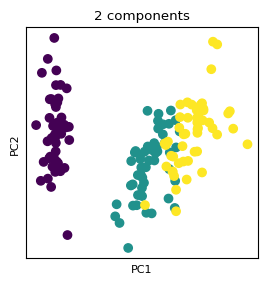

In [139]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(X_proj[:, 0], X_proj[:, 1], c = y)
ax.set_xlabel('PC1'); plt.xticks([])
ax.set_ylabel('PC2'); plt.yticks([])
ax.set_title('2 components');

### Explained Variance

The optimal value for `k` can be tuned by investigating the explained variance. 

The explained variance tells us how much information (variance) can be attributed to each of the principal components.

$$
\text{Explained variance} = \frac{\sum_{i=0}^{r} \lambda_i}{\sum_{i=0}^{m} \lambda_i} = \frac{\lambda_1 + \lambda_2 + \cdots + \lambda_m}{\lambda_1 + \lambda_2 + \cdots + \lambda_r}
$$

where: $r<= m$ 

Explained variance: [72.77 23.03  3.68  0.52]
Cumulative explained variance: [ 72.77  95.8   99.48 100.  ]


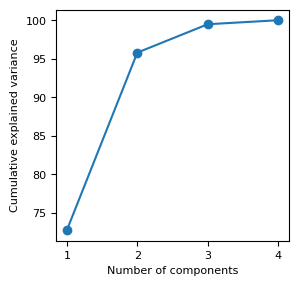

In [140]:
%matplotlib inline

eig_vals_total = sum(eig_vals)
explained_variance = [(i / eig_vals_total)*100 for i in eig_vals]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)

print('Explained variance: {}'.format(explained_variance))
print('Cumulative explained variance: {}'.format(cum_explained_variance))

fig, ax = plt.subplots(figsize= (3, 3))

ax.plot(np.arange(1,n_features+1), cum_explained_variance, '-o')
ax.set_xticks(np.arange(1,n_features+1))
ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

### [OPTIONAL] Comparison to scikit-learn

In [141]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit_transform(X_std)

print('by sklearn:')
print(pca.components_.transpose())

print('ours:')
print(W)

by sklearn:
[[ 0.522  0.372]
 [-0.263  0.926]
 [ 0.581  0.021]
 [ 0.566  0.065]]
ours:
[[ 0.522  0.372]
 [-0.263  0.926]
 [ 0.581  0.021]
 [ 0.566  0.065]]


## Breast Cancer Wisconsin

In this section, we are going to exactly repeat the process but with different dataset. This time we are going to use the "Breast Cancer Winsconsin" dataset. The dataset can be found in [this link.](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

### Load the Dataset

In [142]:
data = np.loadtxt("./datasets/breast_cancer/wdbc.data", delimiter=",", dtype=str)
X = np.float32(data[:, 2:12])  # 10 dimensions

# Diagnosis (M = malignant, B = benign)
y = np.zeros(X.shape[0], dtype=np.int32) 
y[np.where(data[:,1]=='M')] = 1
y[np.where(data[:,1]=='B')] = 0

n_features = X.shape[1]
feature_names = ['#'+str(k) for k in range(n_features)]

print("Dimension numbers :", X.shape[1])
print("Number of data    :", X.shape[0])
print("Labels            :", np.unique(y))

Dimension numbers : 10
Number of data    : 569
Labels            : [0 1]


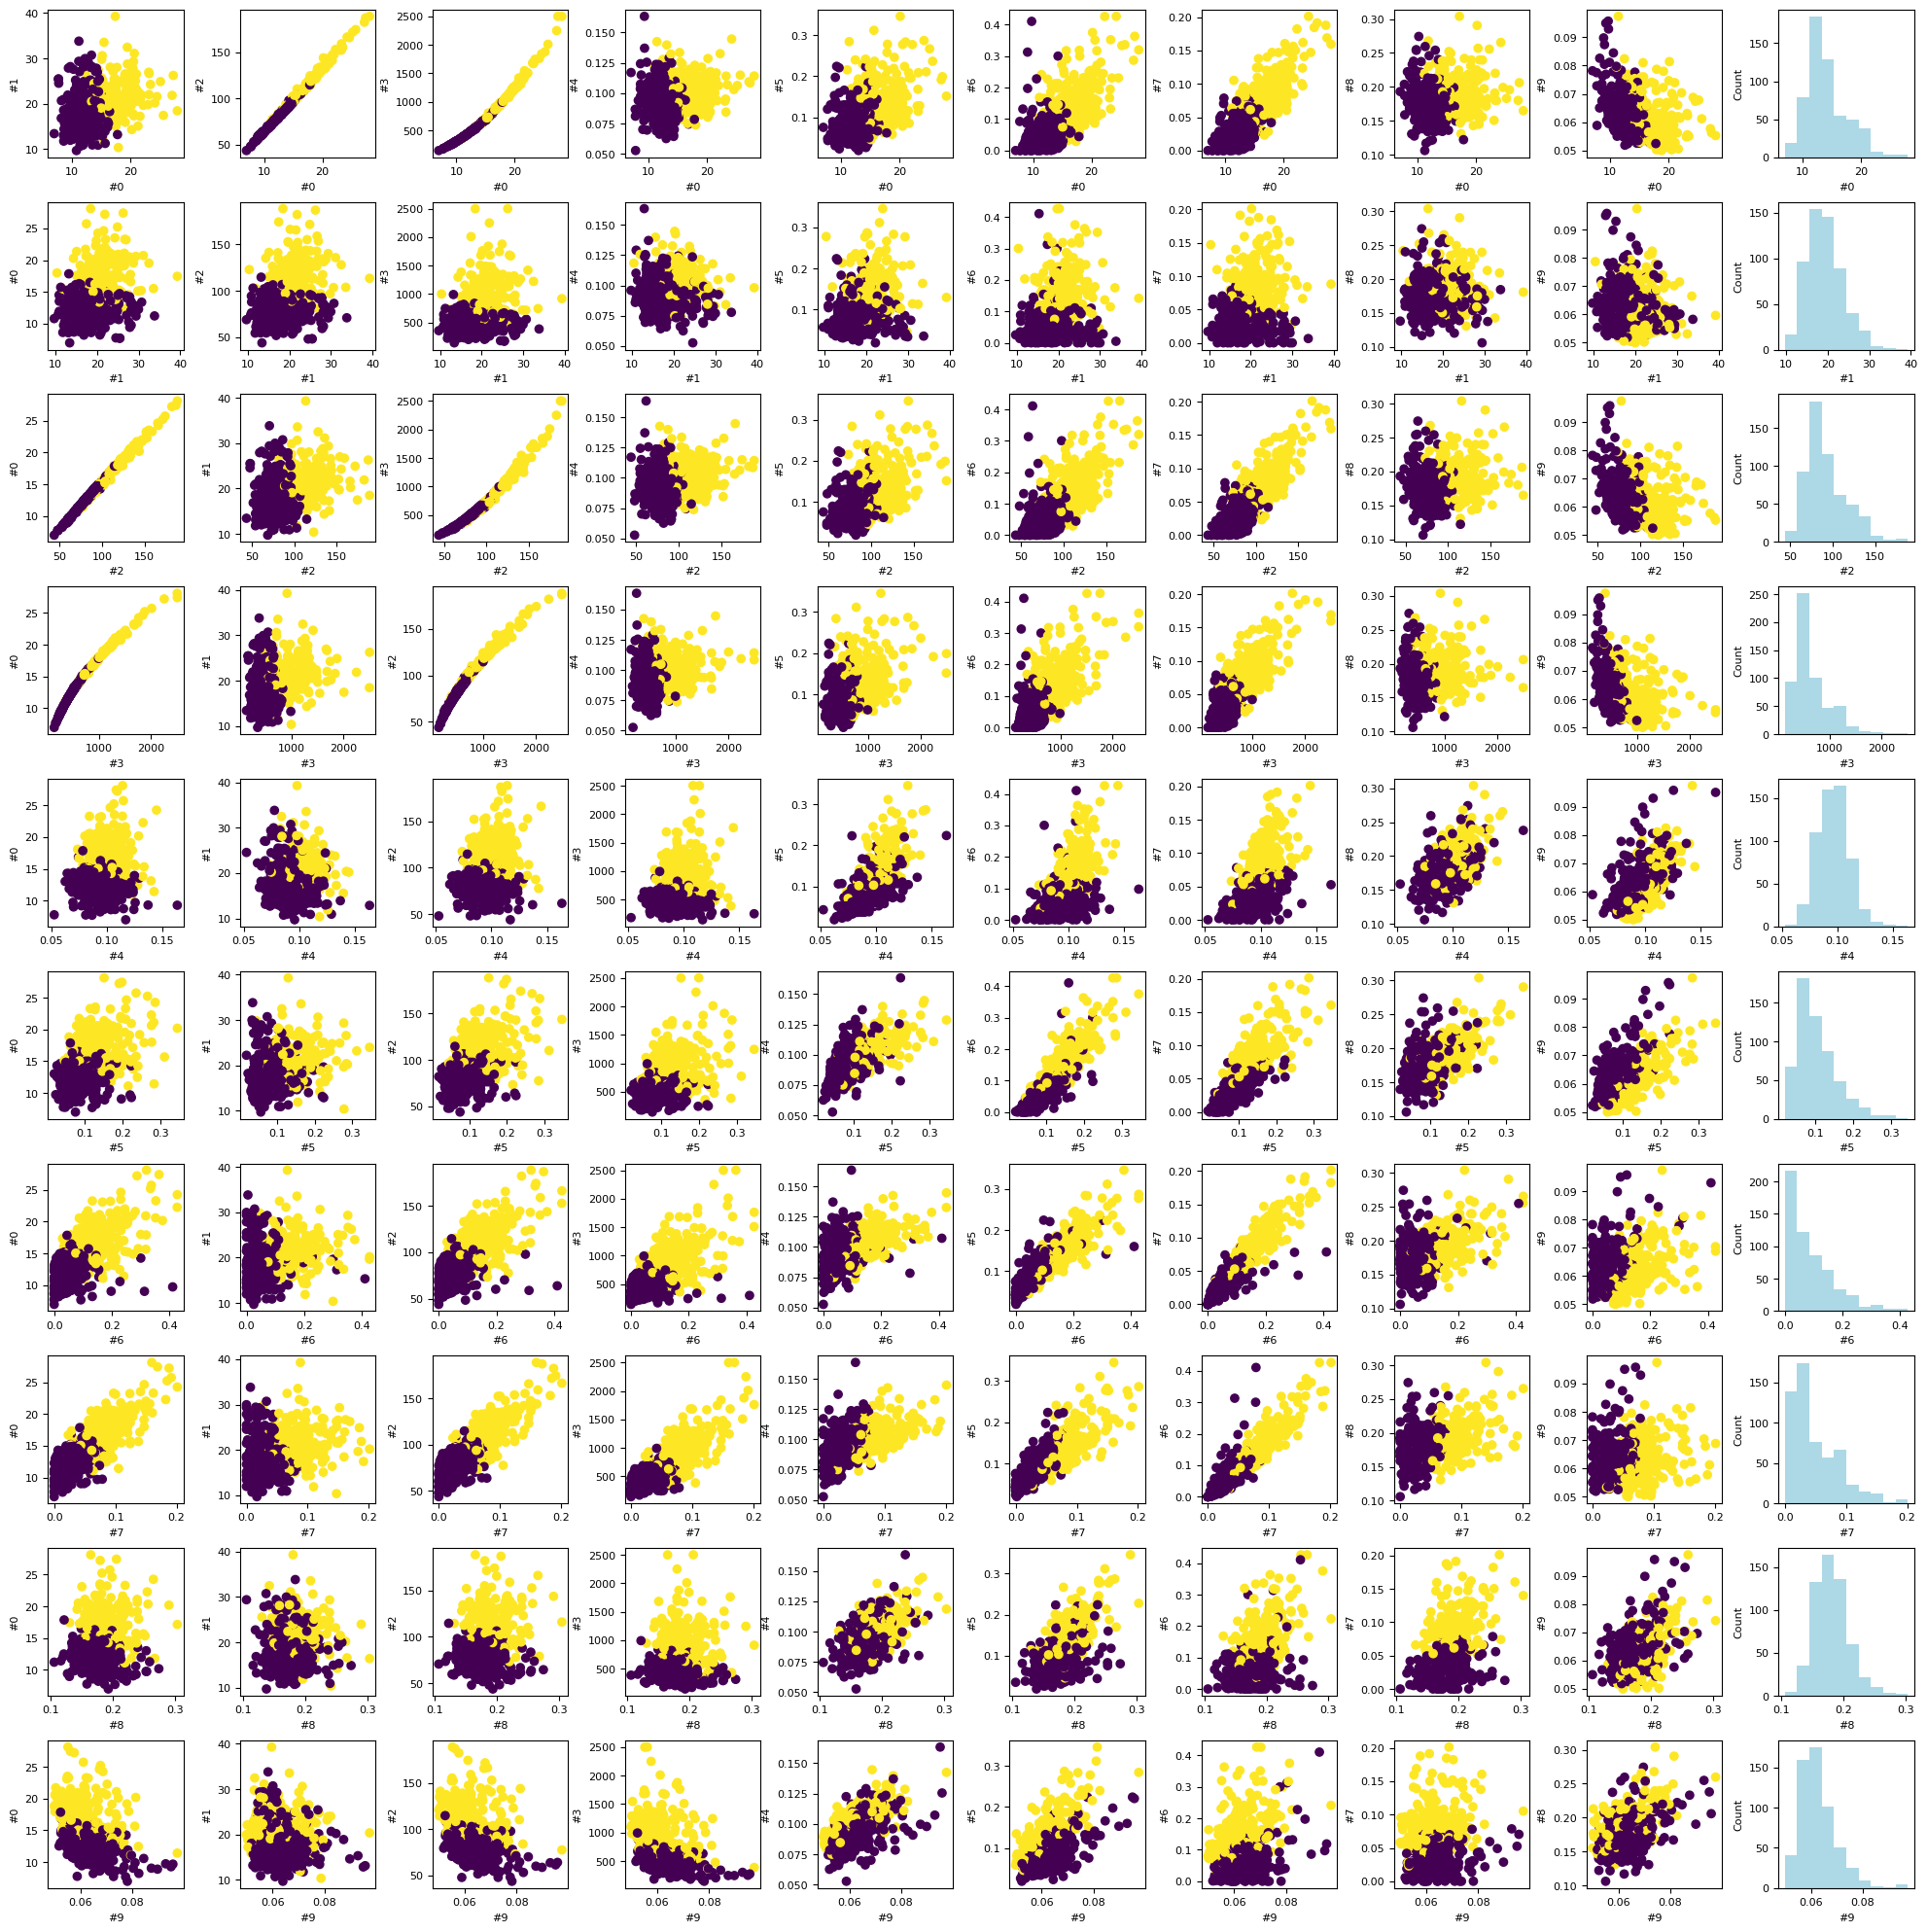

In [143]:
%matplotlib inline

fig, ax = plt.subplots(nrows=n_features, ncols=n_features, figsize= (n_features*2, n_features*2))
fig.tight_layout(pad=2.0)

names = feature_names

for i in range(n_features):
    J = np.arange(n_features)
    J = np.delete(J, i)
    for k, j in enumerate(J):
        ax[i, k].scatter(X[:, i], X[:, j], c = y)
        ax[i, k].set_xlabel(names[i])
        ax[i, k].set_ylabel(names[j])
        
for i in range(n_features):
    ax[i, -1].hist(X[:, i], color = 'lightblue')
    ax[i, -1].set_ylabel('Count')
    ax[i, -1].set_xlabel(names[i])

### Standardization

In [144]:
means  = np.mean(X, axis=0)
stdevs = np.std(X, axis=0)

X_std = (X - means) / stdevs

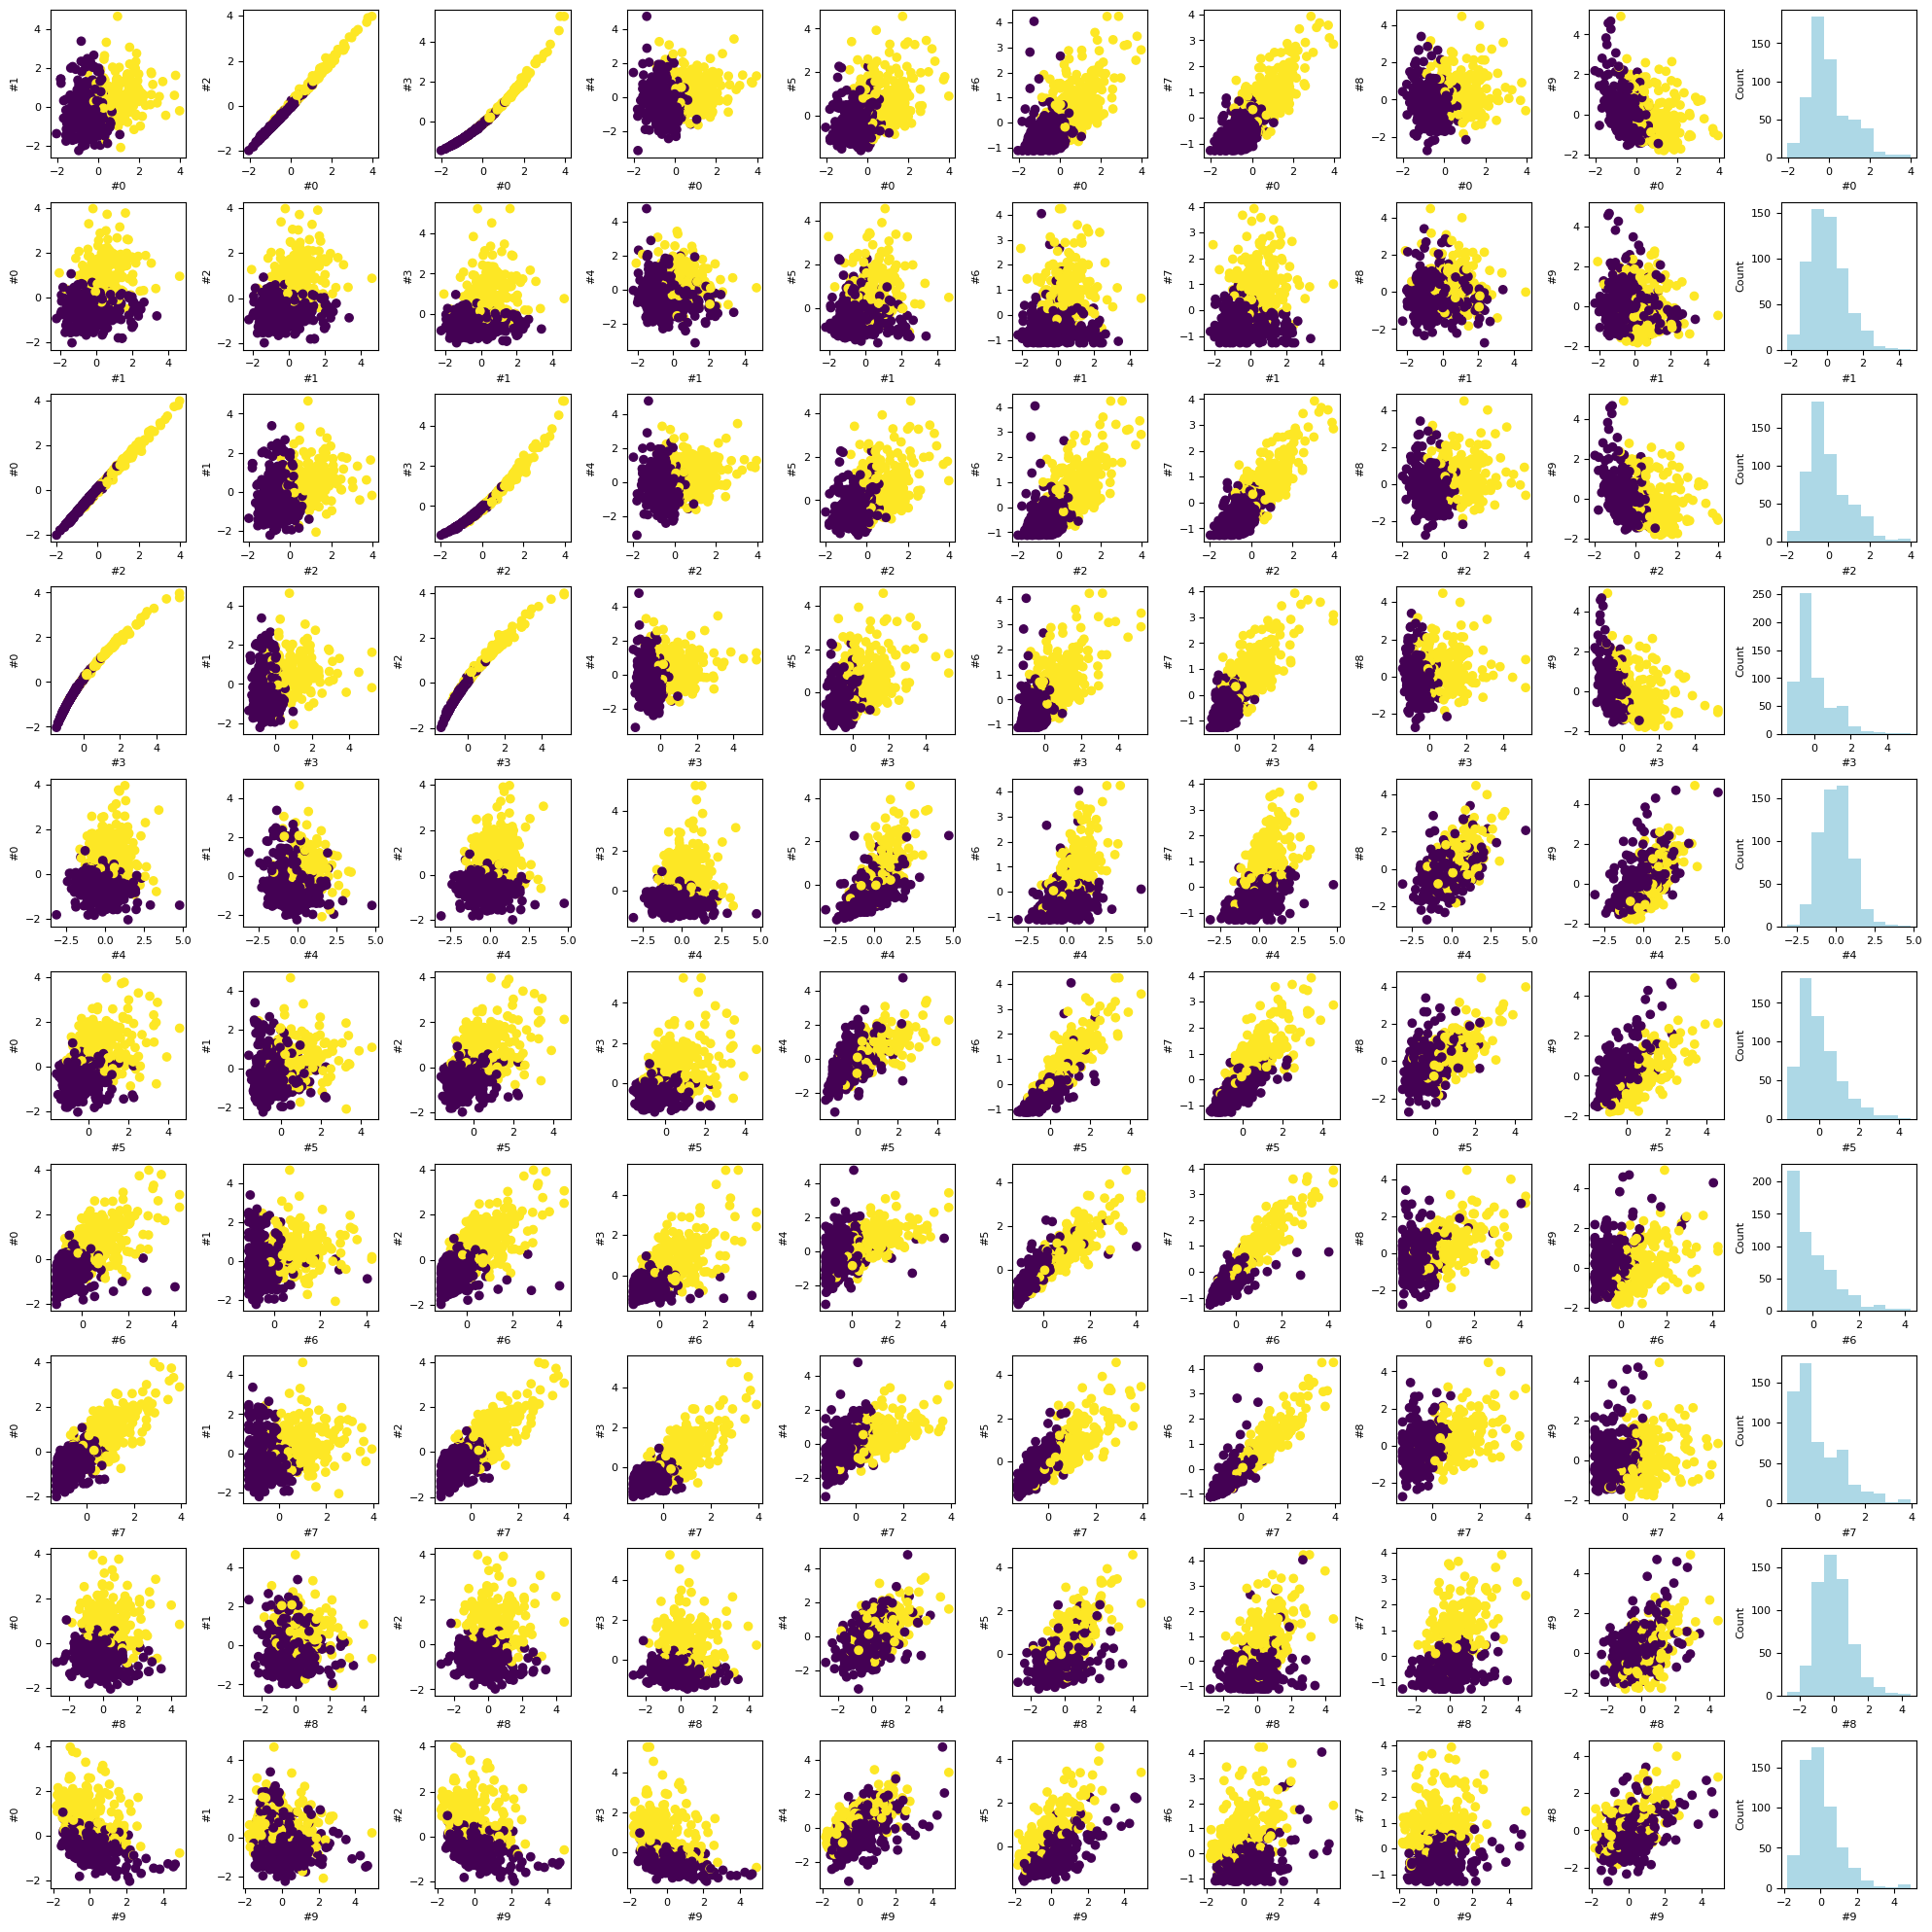

In [145]:
%matplotlib inline

fig, ax = plt.subplots(nrows=n_features, ncols=n_features, figsize= (n_features*2, n_features*2))
fig.tight_layout(pad=2.0)

names = feature_names

for i in range(n_features):
    J = np.arange(n_features)
    J = np.delete(J, i)
    for k, j in enumerate(J):
        ax[i, k].scatter(X_std[:, i], X_std[:, j], c = y)
        ax[i, k].set_xlabel(names[i])
        ax[i, k].set_ylabel(names[j])
        
for i in range(n_features):
    ax[i, -1].hist(X_std[:, i], color = 'lightblue')
    ax[i, -1].set_ylabel('Count')
    ax[i, -1].set_xlabel(names[i])

### Covariance Matrix

In [146]:
cov_mat = np.cov(X_std.T) # square symmetric, positive semi-definite
print(cov_mat)

[[ 1.002  0.324  1.     0.989  0.171  0.507  0.678  0.824  0.148 -0.312]
 [ 0.324  1.002  0.33   0.322 -0.023  0.237  0.303  0.294  0.072 -0.077]
 [ 1.     0.33   1.002  0.988  0.208  0.558  0.717  0.852  0.183 -0.262]
 [ 0.989  0.322  0.988  1.002  0.177  0.499  0.687  0.825  0.152 -0.284]
 [ 0.171 -0.023  0.208  0.177  1.002  0.66   0.523  0.555  0.559  0.586]
 [ 0.507  0.237  0.558  0.499  0.66   1.002  0.885  0.833  0.604  0.566]
 [ 0.678  0.303  0.717  0.687  0.523  0.885  1.002  0.923  0.502  0.337]
 [ 0.824  0.294  0.852  0.825  0.555  0.833  0.923  1.002  0.463  0.167]
 [ 0.148  0.072  0.183  0.152  0.559  0.604  0.502  0.463  1.002  0.481]
 [-0.312 -0.077 -0.262 -0.284  0.586  0.566  0.337  0.167  0.481  1.002]]


### Singular Value Decomposition

In [147]:
U, S, V = np.linalg.svd(cov_mat)
eig_vals = S
eig_vecs = U

print ("Eigen values (lambda):")
print(S)
print()
print("Corresponding Eigen-vector matrix (U):")
print(U)

Eigen values (lambda):
[5.488 2.523 0.882 0.5   0.373 0.124 0.08  0.035 0.011 0.   ]

Corresponding Eigen-vector matrix (U):
[[-0.364  0.314 -0.124 -0.03   0.031  0.264  0.044 -0.085 -0.474  0.669]
 [-0.154  0.147  0.951 -0.009  0.22   0.032 -0.021  0.007 -0.004 -0.   ]
 [-0.376  0.285 -0.114 -0.013  0.006  0.238  0.083 -0.089 -0.38  -0.74 ]
 [-0.364  0.305 -0.123 -0.013  0.019  0.332 -0.261 -0.145  0.747  0.032]
 [-0.232 -0.402 -0.167  0.108  0.844 -0.062 -0.011 -0.171 -0.006 -0.004]
 [-0.364 -0.266  0.058  0.186 -0.24  -0.005  0.804 -0.064  0.219  0.053]
 [-0.396 -0.104  0.041  0.167 -0.313 -0.601 -0.367 -0.45  -0.081  0.01 ]
 [-0.418 -0.007 -0.069  0.073  0.009 -0.266 -0.141  0.851  0.022  0.004]
 [-0.215 -0.368  0.037 -0.893 -0.113  0.062 -0.048 -0.016 -0.009 -0.001]
 [-0.072 -0.572  0.114  0.349 -0.265  0.568 -0.345  0.065 -0.13  -0.007]]


### Correct the Eigen-vector Matrix

In [148]:
# Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
eig_vecs_ = eig_vecs*signs[np.newaxis,:]

print(eig_vals)
print()
print(eig_vecs_)

[5.488 2.523 0.882 0.5   0.373 0.124 0.08  0.035 0.011 0.   ]

[[ 0.364 -0.314 -0.124  0.03   0.031 -0.264  0.044 -0.085 -0.474 -0.669]
 [ 0.154 -0.147  0.951  0.009  0.22  -0.032 -0.021  0.007 -0.004  0.   ]
 [ 0.376 -0.285 -0.114  0.013  0.006 -0.238  0.083 -0.089 -0.38   0.74 ]
 [ 0.364 -0.305 -0.123  0.013  0.019 -0.332 -0.261 -0.145  0.747 -0.032]
 [ 0.232  0.402 -0.167 -0.108  0.844  0.062 -0.011 -0.171 -0.006  0.004]
 [ 0.364  0.266  0.058 -0.186 -0.24   0.005  0.804 -0.064  0.219 -0.053]
 [ 0.396  0.104  0.041 -0.167 -0.313  0.601 -0.367 -0.45  -0.081 -0.01 ]
 [ 0.418  0.007 -0.069 -0.073  0.009  0.266 -0.141  0.851  0.022 -0.004]
 [ 0.215  0.368  0.037  0.893 -0.113 -0.062 -0.048 -0.016 -0.009  0.001]
 [ 0.072  0.572  0.114 -0.349 -0.265 -0.568 -0.345  0.065 -0.13   0.007]]


### Select the Axis Components

In [149]:
# Select top k eigenvectors
k = 3
W = eig_vecs_[:, :k] # Projection matrix
print(W)
print(W.shape)

[[ 0.364 -0.314 -0.124]
 [ 0.154 -0.147  0.951]
 [ 0.376 -0.285 -0.114]
 [ 0.364 -0.305 -0.123]
 [ 0.232  0.402 -0.167]
 [ 0.364  0.266  0.058]
 [ 0.396  0.104  0.041]
 [ 0.418  0.007 -0.069]
 [ 0.215  0.368  0.037]
 [ 0.072  0.572  0.114]]
(10, 3)


### Project the Dataset to the New Axis Components

In [150]:
X_proj = X_std.dot(W)
print(X_proj.shape)

(569, 3)


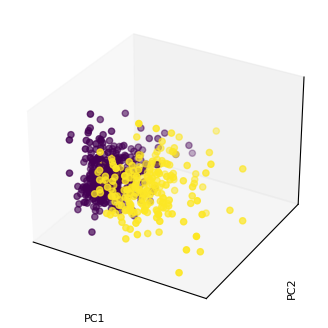

In [151]:
%matplotlib inline

fig = plt.figure(figsize=(4,4));
ax = fig.add_subplot(projection='3d');

ax.scatter(X_proj[:, 0], X_proj[:, 1],  X_proj[:, 2], c = y);

ax.set_xlabel('PC1');
ax.set_xticks([]);
ax.set_ylabel('PC2', rotation=90);
ax.set_yticks([]);
ax.set_zlabel('PC3', rotation=90);
ax.set_zticks([]);


### Explained Variance

Explained variance: [54.79 25.19  8.81  4.99  3.73  1.24  0.8   0.35  0.11  0.  ]
Cumulative explained variance: [ 54.79  79.98  88.79  93.78  97.51  98.75  99.55  99.9  100.01 100.01]


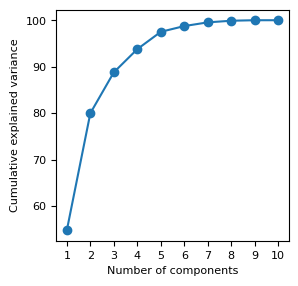

In [152]:
%matplotlib inline

eig_vals_total = sum(eig_vals)
explained_variance = [(i / eig_vals_total)*100 for i in eig_vals]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)

print('Explained variance: {}'.format(explained_variance))
print('Cumulative explained variance: {}'.format(cum_explained_variance))

fig, ax = plt.subplots(figsize= (3, 3))

ax.plot(np.arange(1,n_features+1), cum_explained_variance, '-o')
ax.set_xticks(np.arange(1,n_features+1))
ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

### [OPTIONAL] Comparison to scikit-learn

In [153]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit_transform(X_std)

print('by sklearn:')
print(pca.components_.transpose())

print('ours:')
print(W)

by sklearn:
[[ 0.364 -0.314 -0.124]
 [ 0.154 -0.147  0.951]
 [ 0.376 -0.285 -0.114]
 [ 0.364 -0.305 -0.123]
 [ 0.232  0.402 -0.167]
 [ 0.364  0.266  0.058]
 [ 0.396  0.104  0.041]
 [ 0.418  0.007 -0.069]
 [ 0.215  0.368  0.037]
 [ 0.072  0.572  0.114]]
ours:
[[ 0.364 -0.314 -0.124]
 [ 0.154 -0.147  0.951]
 [ 0.376 -0.285 -0.114]
 [ 0.364 -0.305 -0.123]
 [ 0.232  0.402 -0.167]
 [ 0.364  0.266  0.058]
 [ 0.396  0.104  0.041]
 [ 0.418  0.007 -0.069]
 [ 0.215  0.368  0.037]
 [ 0.072  0.572  0.114]]


## References:

* [Principal Component Analysis from Scratch](https://bagheri365.github.io/blog/Principal-Component-Analysis-from-Scratch/)
* [Principal component analysis. Nat Rev Methods Primers 2, 100 (2022)](https://pure.eur.nl/ws/portalfiles/portal/95076086/Nature_Reviews_Methods_Primer_Greenacre_et_al_2022_PCA.pdf)
* [MIT OCW, Statistics for Applications, Chapter 9: Principal Component Analysis (PCA)](https://ocw.mit.edu/courses/18-650-statistics-for-applications-fall-2016/d85e1a9d113142ade8ce5e4f5ef0b4e8_MIT18_650F16_PCA.pdf)